# Giới thiệu.
- Dataset: HR Analytics: Job Change of Data Scientists.
- Source: ([Kaggle](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists)).
- Bài báo cáo này dựa trên tập dữ liệu của Kaggle về lĩnh vực phân tích nhân sự.
- **Mục tiêu** là xây dựng một mô hình dự đoán cho biết một người có chuyển đổi công việc hay không, dựa trên các yếu tố như kinh nghiệm làm việc, học vấn và các thông tin liên quan khác.

# 1 - Chuẩn bị dữ liệu.

## 1.1 Tải và unzip file.

In [ ]:
%%shell
#https://drive.google.com/file/d/1ijWAXJa28dG9U3h1ACOFt8lIp0EQvT9I/view?usp=sharing
pip -q install --upgrade --no-cache-dir gdown
gdown -q 1ijWAXJa28dG9U3h1ACOFt8lIp0EQvT9I
echo 'download: done => file: HR_Ana.zip'
rm -rf ./HR_Ana/
unzip -q HR_Ana.zip

## 1.2 Import các thư viện cần thiết.

In [ ]:
%%capture
!pip install --upgrade category_encoders

In [ ]:
%matplotlib inline

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce
import plotly.graph_objs as go

from sklearn.svm import SVC
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

- Đường dẫn đến file Train và Test.

In [ ]:
# Đường dẫn đến file CSV
path_train = '/content/HR Ana/aug_train.csv'
path_test ='/content/HR Ana/aug_test.csv'

# Đọc file CSV vào DataFrame
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

## 1.3 Khám phá tập dữ liệu.

In [ ]:
train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


Bên trên là 1 số thông tin về các cột của tập dữ liệu

### 1.3.1 Feature
Tập dữ liệu có 14 thuộc tính:
- 1. enrollee_id: ID duy nhất của từng người trong tập dữ liệu.
- 2. city: Thành phố nơi người lao động đang làm việc.
- 3. city_development_index: Chỉ số phát triển của thành phố.
- 4. gender: Giới tính của người lao động.
- 5. relevent_experience: Kinh nghiệm làm việc có liên quan.
- 6. enrolled_university: Trình độ đào tạo đại học hiện tại.
- 7. education_level: Trình độ học vấn.
- 8. major_discipline: Lĩnh vực chuyên ngành.
- 9. experience: Kinh nghiệm làm việc trong năm.
- 10. company_size: Quy mô công ty hiện tại.
- 11. company_type: Loại công ty hiện tại.
- 12. last_new_job: Số lượng năm kể từ công việc trước đó.
- 13. training_hours: Số giờ đào tạo.
- 14. target: Biến mục tiêu, biểu thị liệu một người có chuyển đổi công việc hay không (1 hoặc 0).


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

Thông tin mô tả:
- 19158 dòng (rows, entries)
- 14 cột (columns, features, attributes)
- Tên thuộc tính - Số lượng giá trị tương ứng (có vẻ như 1 số cột đang bị thiếu).
- Kiểu dữ liệu cho từng cột (4 cột dạng "numerical" và 10 cột dạng "categorical").

###1.3.2 Trực quan dữ liệu bị thiếu.

In [ ]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Tập dữ liệu có 8 cột bị thiếu.

<BarContainer object of 14 artists>

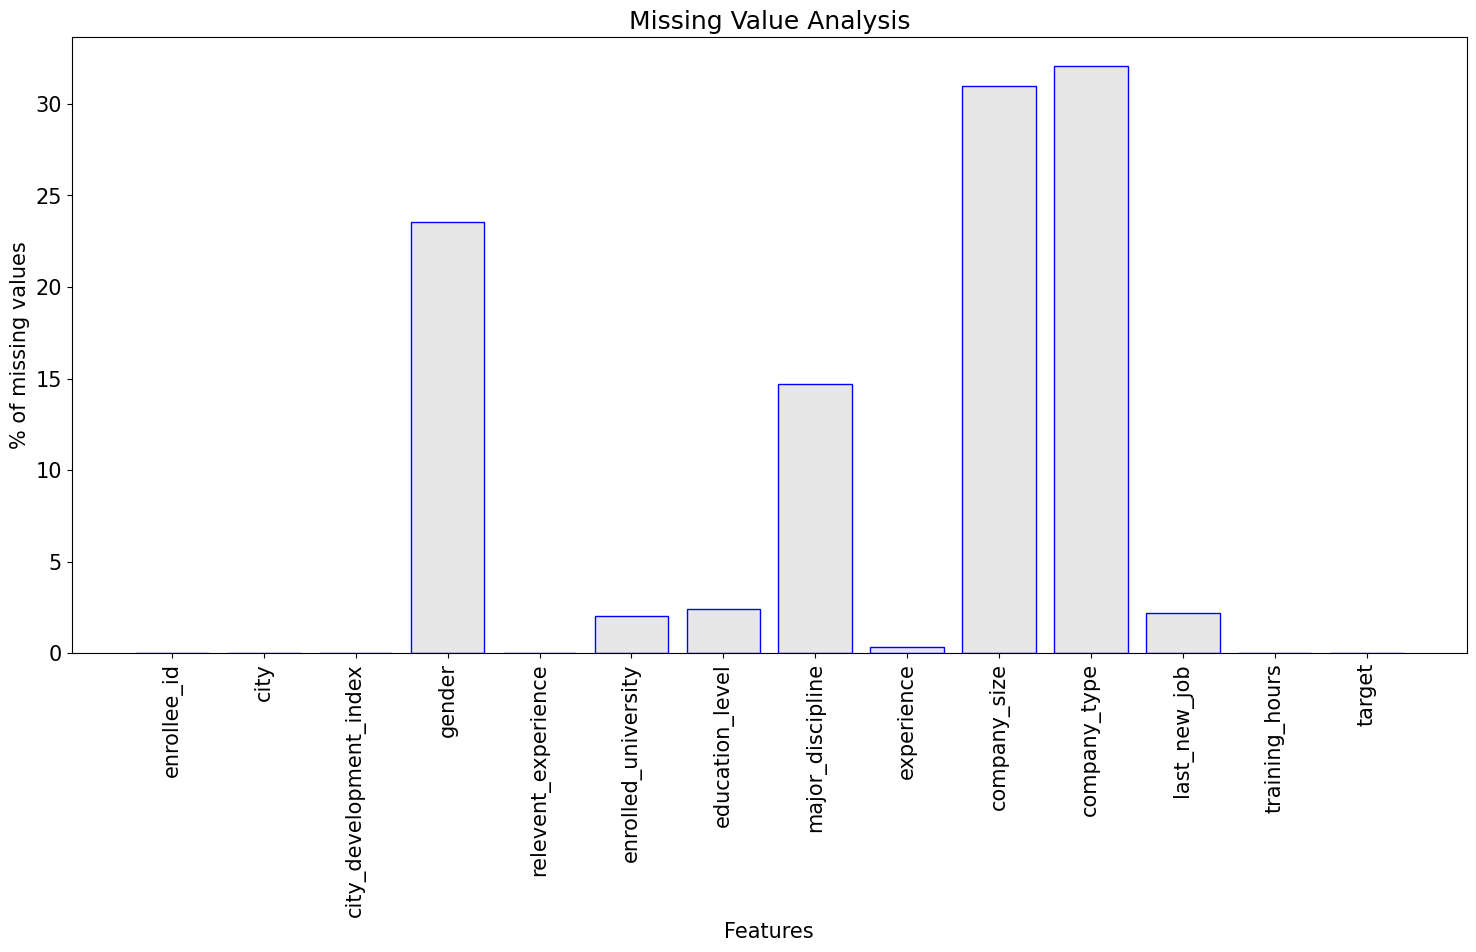

In [ ]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})

plt.figure(figsize = (18,8))
plt.rcParams.update({'font.size': 15})
plt.xticks(rotation=90)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(missing_value_df["column_name"],missing_value_df["percent_missing"],color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')

- Các cột ***gender, major_discipline, company_size, company_type*** thiếu khá nhiều nhưng đây lại là các cột có dạng "categorical" nên có thể dễ dàng xử lí bằng cách fill vào bằng các giá mod (xuất hiện nhiều nhất).
- Các cột còn lại thì có vẻ không đáng kể lắm, cao nhất cũng chỉ khoảng 5%.

###1.3.3 Mô tả các cột Numerical.

In [ ]:
df_categorical = train.select_dtypes(include='object')
df_numerical = train.select_dtypes(exclude='object')

In [ ]:
df_numerical.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


- Tập dữ liệu có 2 cột dạng numrical cần sử dụng là **city_development_index, training_hours**, **enrollee_id** thì không cần tới nên sẽ được loại bỏ.
- **target** là cột nhãn nhưng giá trị 0 và giá trị 1 lại khá chênh lệch khi nhãn 0 chiếm hơn 75% => cần scale dữ liệu lại.
- Các cột **numerial** không có xuất hiện giá trị âm.

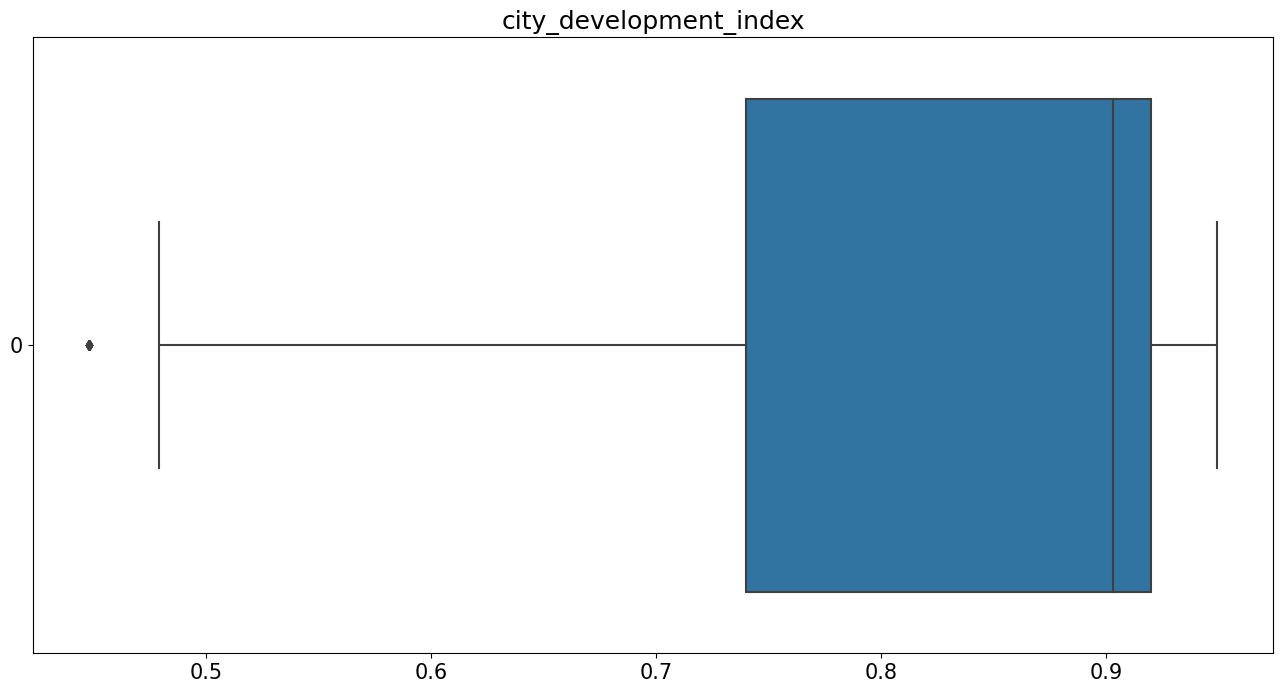

In [ ]:
plt.figure(figsize=(16, 8))
pm_10 = sns.boxplot(train['city_development_index'], orient='h').set_title('city_development_index')

- **city_development_index** hầu như không xuất hiện giá trị **outlier**

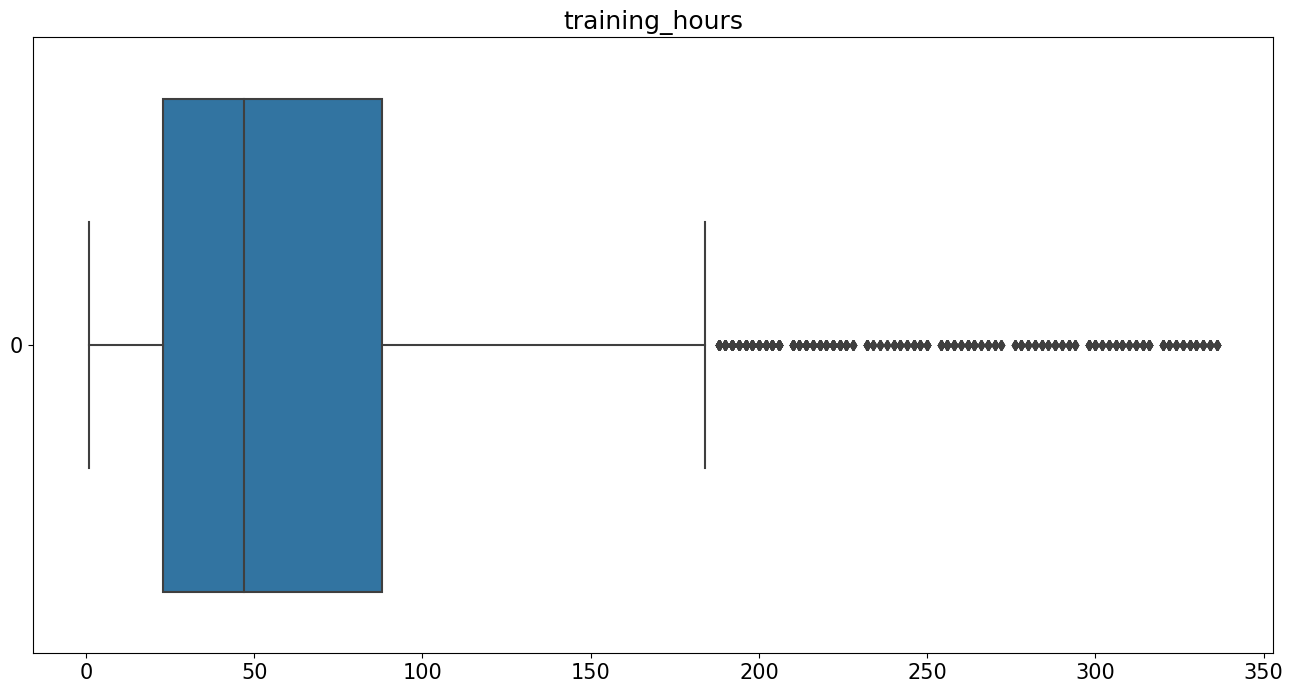

In [ ]:
plt.figure(figsize=(16, 8))
pm_10 = sns.boxplot(train['training_hours'], orient='h').set_title('training_hours')

In [ ]:
(train['training_hours'] >= 175).sum()

1129

- Giả sử cực trên của **training_hours** là 175 thì có 1129 giá trị outlier, chiếm khoảng 6%, khá là nhỏ nên việc loại bỏ là không cần thiết vì đây có thể là các quan sát hiếm hoặc quan trọng của tập dữ liệu.

###1.3.4 Mô tả các cột Categorical

In [ ]:
df_categorical.describe()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


- Đối với các cột **Categorical**, có thể thấy 1 số cột **gender, relevent_experience, enrolled_university, education_level, major_discipline** có các giá trị chiếm hơn 50% tổng số lượng của cột.
- Nhưng vì tập dữ liệu phân tích chuyển đổi công việc của **Data scientist**, 1 ngành mà tỉ lệ nam giới luôn cao hơn nữ => việc scale dữ liệu là không cần thiết.

###1.3.5 Trực quan trình độ giáo dục.

In [ ]:
el = train['education_level'].value_counts().reset_index()
el.columns = [
    'education_level',
    'percent'
]
el['percent'] /= len(train)

fig = px.pie(
    el,
    names='education_level',
    values='percent',
    title='Education_level',
    width=800,
    height=500
)
fig.show()

có 5 mức trình độ giáo dục:
- Graduate: tốt nghiệp
- Masters: Thạc sĩ
- Phd: Tiến sĩ
- High School: Trung học
- Primary School: Tiểu học
- => Tốt nghiệp chiếm đa số và tất nhiên **tiểu học, trung học** khá ít, chưa tới 5%

###1.3.6 Trực quan kinh nghiệm làm việc theo năm.

In [ ]:
ep = train['experience'].value_counts().reset_index()
ep.columns = [
    'experience',
    'percent'
]
ep['percent'] /= len(train)

fig = px.pie(
    ep,
    names='experience',
    values='percent',
    title='Experience',
    width=800,
    height=500
)

fig.show()

20 năm kinh nghiệm chiếm phần lớn giá trị. Nhưng format lại không đồng nhất ("<1" cũng thế) => cần xử lý để về giá trị cụ thể để tránh phát sinh lỗi.

###1.3.7 Trực quan số giờ đào tạo.

Text(0.5, 1.0, 'Distributional of training_hours')

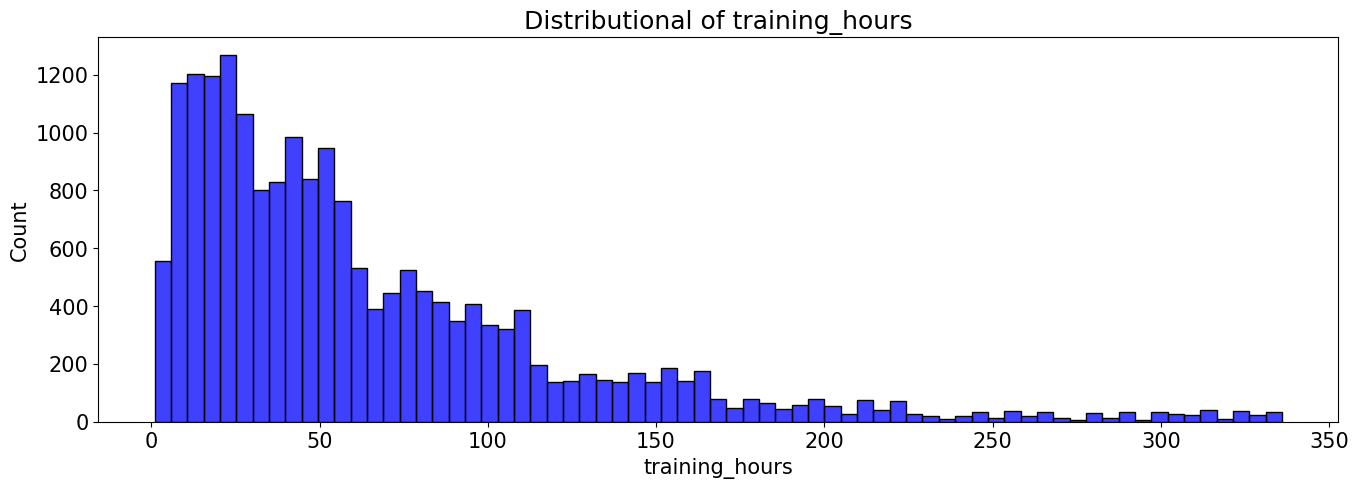

In [ ]:
# Taining_hours
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.histplot(train["training_hours"], color="blue",ax = axes)
plt.title("Distributional of training_hours")

Giá trị trong khoảng 20 giờ đào tạo khá cao và giảm dần.

###1.3.8 Trực quan số giờ đào tạo cho từng trình độ giáo dục.

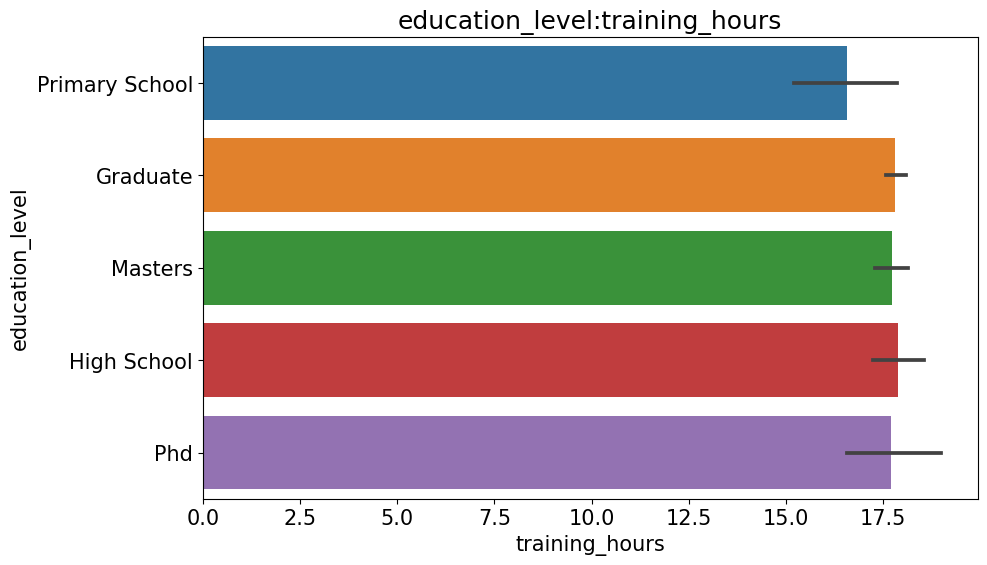

In [ ]:
# education_level:training_hours
et = train.sort_values(by='training_hours', ascending=True)[:7000]
figure = plt.figure(figsize=(10,6))
sns.barplot(y=et.education_level, x=et.training_hours)
plt.xticks()
plt.xlabel('training_hours')
plt.ylabel('education_level')
plt.title('education_level:training_hours')
plt.show()

- Như có thể thấy thì số giờ đào tạo của từng trình độ là gần bằng nhau, cho thấy biểu đồ bên trên bị lệch về bên trái là hoàn toàn có cơ sở.

### 1.3.9 Trực quan giá trị cho cột company_size

In [ ]:
ep = train['company_size'].value_counts().reset_index()
ep.columns = [
    'company_size',
    'percent'
]
ep['percent'] /= len(train)

fig = px.pie(
    ep,
    names='company_size',
    values='percent',
    title='company_size',
    width=800,
    height=500
)

fig.show()

Thông tin của cột **company_size** là các khoảng giá trị chỉ độ lớn của công ty, nhưng "10000+","10/49" và "<10" lại không cùng format => cần biến để dữ liệu đồng nhất.

## 1.4 Tiền xử lý dữ liệu.

###1.4.1 Định nghĩa các hàm cần thiết.

Hàm mô tả chi tiết datafame.

In [ ]:
def show_details(df):
    print("Shape of the Dataframe ",df.shape)
    print("\n")
    print("Null Value Counts of the features in Dataframe \n\n",df.isna().sum())
    print("\n")
    print("Datatypes of the features in Dataframe \n\n",df.dtypes)

Hàm **clean_experience** sẽ thay thế các giá trị ">20" và "<1" thành 27 và 0

In [ ]:
def clean_experience(df):
    for i in df["experience"]:
        if(i==">20"):
            df["experience"][df["experience"]==i]=27
        if(i == "<1"):
            df["experience"][df["experience"]==i]=0

    df["experience"] = df["experience"].fillna(0)
    df["experience"] = df['experience'].astype('int')

Hàm **clean_NAN**, xử lí các giá trị **NAN** và fill bằng giá trị **mode** đối với **Categorical** và **mean** đối với **Numerial**

In [ ]:
def clean_NAN(df):
    df["gender"] = df["gender"].fillna(df["gender"].mode().iloc[0])
    df["education_level"] = df["education_level"].fillna(df["education_level"].mode().iloc[0])
    df["major_discipline"].fillna(value=df["major_discipline"].mode().iloc[0], inplace=True)
    df["experience"] = df["experience"].fillna(df["experience"].mean())
    df["company_type"] = df["company_type"].fillna(df["company_type"].mode().iloc[0])

Hàm **clean_company_size_1** chuyển đổi và xử lí trong cột **company_size**. Chuyển các giá trị nhất định thành các khoảng, , điền giá trị NaN cho cột => tách cột thành hai cột mới để lưu trữ giá trị tối thiểu và tối đa của kích thước công ty. (VD: 50-99 thì 50 sẽ vào cột min và 99 sẽ vào cột max)

In [ ]:
def clean_company_size_1(df):
    converted_list_1 = []
    converted_list_2 = []
    converted_list_3 = []
    for i in df["company_size"]:
        if i == "10/49":
            i = "10-49"
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == "<10":
            i = '1-9'
            converted_list_2.append(i)
        converted_list_2.append(i)
        if i == "10000+":
            i = '10000-20000'
            converted_list_3.append(i)
        converted_list_3.append(i)
    df["company_size"]=pd.Series(converted_list_1)
    df["company_size"]=pd.Series(converted_list_2)
    df["company_size"]=pd.Series(converted_list_3)
    df["company_size"]=df["company_size"].fillna("0-0")
    new = df['company_size'].str.split("-", n = 1, expand = True)
    df['company_size_min']= new[0]
    df['company_size_max']= new[1]
    df["company_size_max"] = df['company_size_max'].astype('int')
    df["company_size_min"] = df['company_size_min'].astype('int')

Hàm **clean_last_new_job** thay thế các giá trị "never" bằng 0, giá trị ">4" bằng 6 và giá trị NaN bằng 0 trong cột "last_new_job"

In [ ]:
def clean_last_new_job(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["last_new_job"]:
        if i == "never" or i == np.NaN:
            i = 0
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == ">4":
            i = 6
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["last_new_job"]=pd.Series(converted_list_1)
    df["last_new_job"]=pd.Series(converted_list_2)
    df["last_new_job"] = df["last_new_job"].fillna(0)
    df["last_new_job"] = df["last_new_job"].astype('int')

Hàm **clean_city** oại bỏ phần tử "city_" trong các giá trị của cột "city" và chuyển đổi chúng thành kiểu số nguyên (int). (VD: city_1 => 1)

In [ ]:
def clean_city(df):
    converted_list_1 = []
    for i in range(len(df["city"])):
        j = df["city"][i].replace("city_","")
        converted_list_1.append(j)
    df["city"]=pd.Series(converted_list_1)
    df["city"] = df["city"].astype('int')

Hàm **clean_relevent_experience** chuyển đổi các giá trị "Has relevent experience" thành 1 và "No relevent experience" thành 0 và gán lại cho cột **"relevent_experience"**






In [ ]:
def clean_relevent_experience(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["relevent_experience"]:
        if i == "Has relevent experience":
            i = 1
            converted_list_1.append(i)
        converted_list_1.append(i)
        if i == "No relevent experience":
            i = 0
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["relevent_experience"]=pd.Series(converted_list_1)
    df["relevent_experience"]=pd.Series(converted_list_2)

Mã hóa one-hot cho các cột **enrolled_university, gender, education_level, major_discipline, company_type**


In [ ]:
def one_hot_encoding(df,col):
    one_hot_encoder=ce.OneHotEncoder(cols=col,return_df=True,use_cat_names=True)
    df_final = one_hot_encoder.fit_transform(df)
    return df_final

# Applying one hot encoding on all required columns
def apply_one_hot_encoding(df):
    df_final = one_hot_encoding(df,"enrolled_university")
    df_final = one_hot_encoding(df_final,"gender")
    df_final = one_hot_encoding(df_final,"education_level")
    df_final = one_hot_encoding(df_final,"major_discipline")
    df_final = one_hot_encoding(df_final,"company_type")
    return df_final

Hàm **clean_company_size_2** sẽ tiếp tục công việc của hàm **clean_company_size_1** sau khi đã encode, vì lúc này mới có thể thay thế các giá trị 0 và NAN bằng **Mean**.

In [ ]:
def clean_company_size_2(df):
    converted_list_1 = []
    converted_list_2 = []
    for i in df["company_size_min"]:
        if i == 0:
            i = int(df["company_size_min"].mean())
            converted_list_1.append(i)
        converted_list_1.append(i)
    for i in df["company_size_max"]:
        if i == 0:
            i = int(df["company_size_max"].mean())
            converted_list_2.append(i)
        converted_list_2.append(i)
    df["company_size_min"]=pd.Series(converted_list_1)
    df["company_size_max"]=pd.Series(converted_list_2)
    df["company_size_min"] = df["company_size_min"].fillna(int(df["company_size_min"].mean()))
    df["company_size_max"] = df["company_size_max"].fillna(int(df["company_size_max"].mean()))

Loại bỏ 2 cột **enrollee_id,company_size** , cột id là không cần thiết, còn cột company_size thì đã được tách ra 2 cột khác mang giá trị tương đương.

In [ ]:
def remove_columns(df):
    df_final = df.drop(['enrollee_id','company_size'],axis=1)
    return df_final

Chia Dataframe thành 2 phần X (các đặc trưng) và Y (Nhãn) để có thể train model cho sau này.

In [ ]:
def XY_Split(df):
    X = df.drop("target",axis=1)
    Y = pd.DataFrame(df["target"])
    return X,Y

###1.4.2 Biến đổi và làm sạch
khi có đủ các hàm cần thiết, tiến hành làm sạch.

In [ ]:
def clean_data(df):
    clean_experience(df)
    clean_NAN(df)
    clean_company_size_1(df)
    clean_last_new_job(df)
    clean_city(df)
    clean_relevent_experience(df)
    df_one_hot = apply_one_hot_encoding(df)
    clean_company_size_2(df_one_hot)
    df_final = remove_columns(df_one_hot)
    X,Y = XY_Split(df_final)
    return df_final,X,Y

In [ ]:
df_final, X, Y = clean_data(train)

In [ ]:
df_final

,city,city_development_index,gender_Male,gender_Female,gender_Other,relevent_experience,enrolled_university_no_enrollment,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_nan,...,company_type_Funded Startup,company_type_Early Stage Startup,company_type_Other,company_type_Public Sector,company_type_NGO,last_new_job,training_hours,target,company_size_min,company_size_max
0,103,0.920,1,0,0,1,1,0,0,0,...,0,0,0,0,0,1,36,1.0,2124,4476
1,40,0.776,1,0,0,0,1,0,0,0,...,0,0,0,0,0,6,47,0.0,2124,4476
2,21,0.624,1,0,0,0,0,1,0,0,...,0,0,0,0,0,6,83,0.0,50,99
3,115,0.789,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,52,1.0,2124,4476
4,162,0.767,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,8,0.0,2124,4476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,173,0.878,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,42,1.0,10000,20000
19154,103,0.920,1,0,0,0,1,0,0,0,...,0,0,0,0,0,4,52,1.0,2124,4476
19155,103,0.920,1,0,0,1,1,0,0,0,...,0,0,0,0,0,6,44,0.0,2124,4476
19156,65,0.802,1,0,0,1,1,0,0,0,...,0,0,0,0,0,6,97,0.0,50,99


In [ ]:
show_details(X)

Shape of the Dataframe  (19158, 32)


Null Value Counts of the features in Dataframe 

 city                                    0
city_development_index                  0
gender_Male                             0
gender_Female                           0
gender_Other                            0
relevent_experience                     0
enrolled_university_no_enrollment       0
enrolled_university_Full time course    0
enrolled_university_Part time course    0
enrolled_university_nan                 0
education_level_Graduate                0
education_level_Masters                 0
education_level_High School             0
education_level_Phd                     0
education_level_Primary School          0
major_discipline_STEM                   0
major_discipline_Business Degree        0
major_discipline_Arts                   0
major_discipline_Humanities             0
major_discipline_No Major               0
major_discipline_Other                  0
experience                    

Số lượng dữ liệu vẫn giữ nguyên, số đặc trưng tăng lên do đã qua xử lý **Encode**.

Dựa vào thông tin từ hàm **Show_details** trên, có thể thấy rõ dữ liệu đã được làm sạch và đưa về dạng **Numerial** để mô hình có thể học được, Số lượng dữ liệu vẫn giữ nguyên.

In [ ]:
df_final = X.copy()
df_final['target'] = Y

df_final.to_csv("Cleaned.csv",index = False)

### 1.4.3 Cân bằng dữ liệu cho cột Target

0.0    14381
1.0     4777
Name: target, dtype: int64


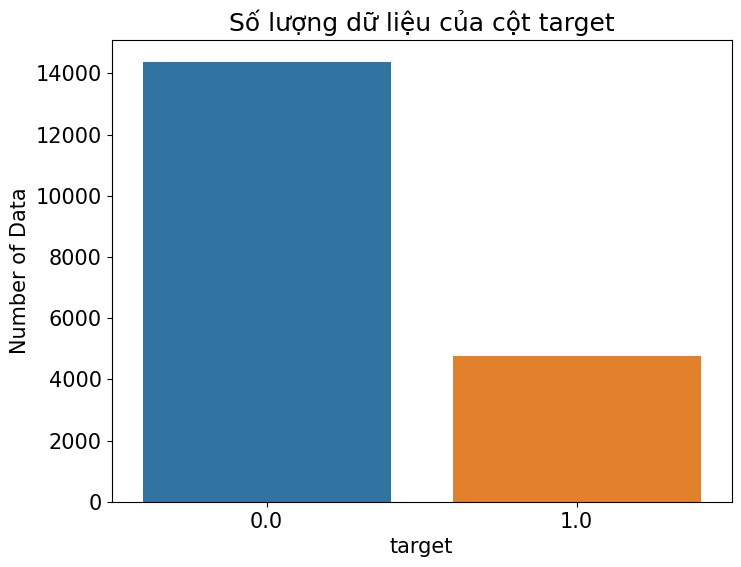

In [ ]:
# 0 – Chuyển đổi công việc
# 1 – không chuyển đổi công việc
mnj = Y['target'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=mnj.index, y=mnj.values)
plt.ylabel('Number of Data')
plt.xlabel('target')
plt.title('Số lượng dữ liệu của cột target')
print(mnj)
plt.show()

Biểu đồ cho thấy dữ liệu không cân bằng, Nhãn 1 (chuyển đổi công việc) chiếm khoảng 20% và 0 (không chuyển đổi) chiểm 80% => cần upscale để duy trình trạng thái cân bằng và giúp cho mô hình không thiên vị khi dự đoán.

In [ ]:
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

SMOTE hoạt động bằng cách chọn các ví dụ gần nhau trong không gian đặc trưng, vẽ một đường thẳng giữa các ví dụ trong không gian đặc trưng và tạo một mẫu mới tại một điểm nằm trên đường đó.

1.0    14381
0.0    14381
Name: target, dtype: int64


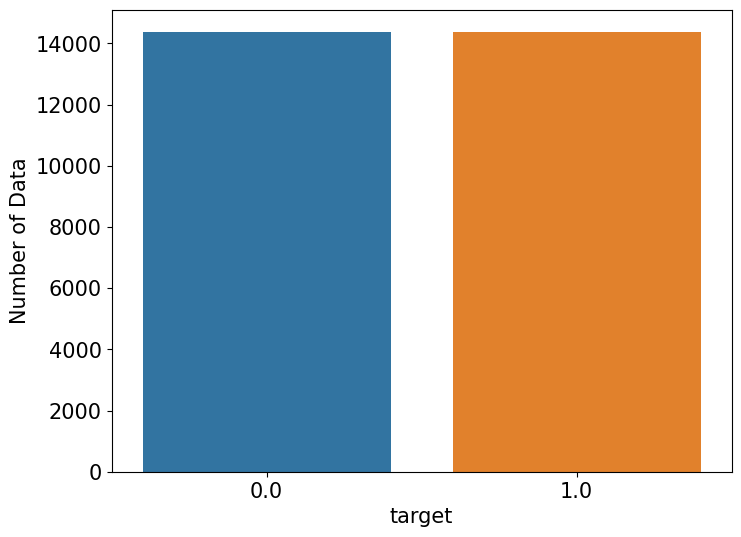

In [ ]:
mnj = Y['target'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=mnj.index, y=mnj.values)
plt.ylabel('Number of Data')
plt.xlabel('target')
print(mnj)
plt.show();

Cột **Target** đã cân bằng.

In [ ]:
show_details(X)

Shape of the Dataframe  (28762, 32)


Null Value Counts of the features in Dataframe 

 city                                    0
city_development_index                  0
gender_Male                             0
gender_Female                           0
gender_Other                            0
relevent_experience                     0
enrolled_university_no_enrollment       0
enrolled_university_Full time course    0
enrolled_university_Part time course    0
enrolled_university_nan                 0
education_level_Graduate                0
education_level_Masters                 0
education_level_High School             0
education_level_Phd                     0
education_level_Primary School          0
major_discipline_STEM                   0
major_discipline_Business Degree        0
major_discipline_Arts                   0
major_discipline_Humanities             0
major_discipline_No Major               0
major_discipline_Other                  0
experience                    

Sau khi đã **Upscaling** thì kích thước tập dữ liệu đã tăng lên nhưng số đặc trưng không đổi. **"SMOTE"** đã tạo ra các mẫu mới cho nhãn 1 và giữ nguyên số lượng mẫu của nhãn 0.

## 1.5 chia tập dữ liệu cho train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

X_test_copy = X_test.copy() #Tránh mất mát dữ liệu khi train.

In [ ]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (23009, 32)
X_test.shape:  (5753, 32)
y_train.shape:  (23009, 1)
y_test.shape:  (5753, 1)


Kích thước sau khi phân chia:
- X_train: (23009, 32) - chứa dữ liệu đặc trưng của tập huấn luyện, với 15326 mẫu và 32 đặc trưng.
- X_test: (5753, 32) - chứa dữ liệu đặc trưng của tập kiểm tra, với 3832 mẫu và 32 đặc trưng.
- y_train: (23009, 1) - chứa nhãn của tập huấn luyện, với 15326 mẫu.
- y_test: (5753, 1) - chứa nhãn của tập kiểm tra, với 3832 mẫu.

# 2- Tạo và Huấn luyện mô hình.

The following sections require variables:
* Trainning set:
  * X_train: shape $(N_{train}, D)$
  * y_train: shape $(N_{train}, )$

* Testing set:
  * X_test: shape $(N_{test}, D)$
  * y_test: shape $(N_{test}, )$


## 2.1 Định nghĩa hàm huấn luyện.

hai hàm **generate_pipes** và **find_hyperparams** tạo ra và tinh chỉnh các ống xử lý dữ liệu dựa trên cấu hình và tham số cho trước, để tìm ra ống tốt nhất cho bài toán phân loại nhãn (0 - 1)

In [ ]:
def generate_pipes(pipe_config):
  pipe_config = [list(step.items()) for _, step in pipe_config]
  pipe_config = list(itertools.product(*pipe_config))
  pipe_names = list(map(lambda steps: [name for name,_ in steps], pipe_config))
  pipe_names = list(map(lambda L: ">".join(L), pipe_names))
  pipes = [Pipeline(cfg) for cfg in pipe_config]
  return dict(zip(pipe_names, pipes))

def find_hyperparams(pipe_mapper):
  print("Start the tunning process ...")
  best_pipes = {}
  results = []
  for idx, pipe_name in enumerate(list(pipe_mapper.keys())):
    print(f"{idx + 1}. Tuning pipe: {pipe_name}")

    # Select parameters related to the current pipeline:
    param_grid = {}
    for step_name in pipe_name.split('>'):
      for param_name in parameters.keys():
        if param_name.startswith(step_name):
          param_grid[param_name] = parameters[param_name]

    # Create a finder and search for the best parameters
    pipe = pipe_mapper[pipe_name]
    finder = GridSearchCV(pipe, param_grid=param_grid, cv=5,
                          scoring= "accuracy",
                          refit= True)

    finder.fit(X_train, y_train)
    print("\t best-params: {:>15s}".format(str(finder.best_params_)))
    print(f"\t best-score (accuracy): {finder.best_score_:15.2f}")
    print()

    # Store best pipe
    best_pipes[pipe_name] = finder.best_estimator_

    # Add results to a dataframe
    rs_item = {"Method": pipe_name, "Accuracy": finder.best_score_}
    for key, value in finder.best_params_.items():
      rs_item[key] = value
    results.append(rs_item)

  print("The tunning is done!")
  tuned_table = pd.DataFrame(results)
  tuned_table.set_index('Method')
  return tuned_table, best_pipes

## 2.2 Định nghĩa pipeplines
  1. Định nghĩa **pipe_steps**. Đây là một danh sách tuples với mỗi tuple sẽ có 2 phần tử:
    * Phần tử thứ 1: Một chuỗi, tên của bước (Step).
    * Phần tử thứ 2: Một từ điển (Dictionary), ánh xạ từ tên phương thức đến đối tượng phương thức, ví dụ như **scalers**,  **classifiers**
  2. Định nghĩa **parameters**. Đây là một từ điển, ánh xạ từ các tham số đến danh sách các giá trị có thể của chúng.
    * Tên của tham số:
      * **Tên phương thức** + **(2 dấu gạch chân, __)** + **tên tham số**






- **scalers và classifiers** chứa các phương pháp **Scaling và Phân loại** đã chọn.
- **parameters** là các tham số dung cho mô hình huấn luyện, được đặt tên theo quy tắc của SKlearn.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Define methods for scaling features
scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler()
}

# Define methods for classifying samples
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

pipe_steps = [
    ('scaler', scalers),
    ('classifier', classifiers)
]

# Define parameters for each method
parameters = {
    "MinMaxScaler__feature_range": [(0, 1), (-1, 1)],
    "StandardScaler__with_mean": [True, False],
    "StandardScaler__with_std": [True, False],
    "MLPClassifier__hidden_layer_sizes": [(64,), (128,)],
    "MLPClassifier__activation": ['relu'],
    "DecisionTreeClassifier__criterion": ['entropy'],
    "RandomForestClassifier__n_estimators": [50, 100],
    "RandomForestClassifier__criterion": ['entropy'],
}

Lựa chọn 2 phương scaling **MinMaxScaler và StandardScaler** vì nó phù hợp với tập dữ liệu, tập dữ liệu không có giá trị âm.
- MinMaxScaler chuyển đổi các giá trị của đặc trưng thành khoảng [0, 1] [-1, 1].
- StandardScaler biến đổi các giá trị thành dạng có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1.

Lựa chọn 4 phương pháp phân loại trên vì 1 số lợi ích nó mang lại:
- Hiệu suất tốt.
- Mạnh mẽ và ổn định.
- Xử lý tốt với các dự liệu có đặc trưng quan trọng (Random Forest)
- Huấn luyện nhanh (dễ quan sát cho quá trình nghiên cứu và phân tích).


- 1.Logistic Regression: Một thuật toán phân loại sử dụng hàm logistic để dự đoán xác suất của một mẫu thuộc vào một lớp cụ thể. Thường được sử dụng cho bài toán phân loại nhị phân hoặc đa lớp.

- 2.MLPClassifier: Một mô hình học sâu dựa trên mạng nơ-ron nhân tạo đa lớp. Sử dụng lan truyền ngược để điều chỉnh trọng số mạng nơ-ron và phân loại đa lớp.

- 3.Decision Tree Classifier: Một thuật toán dựa trên cây quyết định, tạo ra các quy tắc phân loại dựa trên phân chia dữ liệu theo các đặc trưng. Dễ hiểu, xử lý dữ liệu không đồng nhất và có thể sử dụng cho phân loại và hồi quy.

- 4.RandomForestClassifier: Một mô hình học máy dựa trên việc kết hợp nhiều cây quyết định thành một tập hợp. Kết hợp dự đoán từ các cây để tạo ra dự đoán cuối cùng. Thích hợp cho bài toán phân loại và xử lý dữ liệu lớn, không đồng nhất và chứa nhiễu.

## 2.3 Tune hyper-parameters

Tìm kiếm và xác định các giá trị tối ưu cho các tham số của mô hình.

In [ ]:
pipe_mapper = generate_pipes(pipe_steps)
tuned_table, best_pipes = find_hyperparams(pipe_mapper)

Start the tunning process ...
1. Tuning pipe: MinMaxScaler>LogisticRegression
	 best-params: {'MinMaxScaler__feature_range': (-1, 1)}
	 best-score (accuracy):            0.82

2. Tuning pipe: MinMaxScaler>MLPClassifier
	 best-params: {'MLPClassifier__activation': 'relu', 'MLPClassifier__hidden_layer_sizes': (64,), 'MinMaxScaler__feature_range': (0, 1)}
	 best-score (accuracy):            0.82

3. Tuning pipe: MinMaxScaler>DecisionTreeClassifier
	 best-params: {'DecisionTreeClassifier__criterion': 'entropy', 'MinMaxScaler__feature_range': (0, 1)}
	 best-score (accuracy):            0.77

4. Tuning pipe: MinMaxScaler>RandomForestClassifier
	 best-params: {'MinMaxScaler__feature_range': (-1, 1), 'RandomForestClassifier__criterion': 'entropy', 'RandomForestClassifier__n_estimators': 100}
	 best-score (accuracy):            0.83

5. Tuning pipe: StandardScaler>LogisticRegression
	 best-params: {'StandardScaler__with_mean': True, 'StandardScaler__with_std': True}
	 best-score (accuracy):    

### 2.3.1 Trực quan bằng bảng biểu.

Thông số của các **pipeline** sau khi huấn luyện.

In [ ]:
cm = sns.light_palette("purple", as_cmap=True)
tuned_table.style.background_gradient(cmap=cm).set_precision(3)

,Method,Accuracy,MinMaxScaler__feature_range,MLPClassifier__activation,MLPClassifier__hidden_layer_sizes,DecisionTreeClassifier__criterion,RandomForestClassifier__criterion,RandomForestClassifier__n_estimators,StandardScaler__with_mean,StandardScaler__with_std
0,MinMaxScaler>LogisticRegression,0.817,"(-1, 1)",nan,nan,nan,nan,nan,nan,nan
1,MinMaxScaler>MLPClassifier,0.817,"(0, 1)",relu,"(64,)",nan,nan,nan,nan,nan
2,MinMaxScaler>DecisionTreeClassifier,0.774,"(0, 1)",nan,nan,entropy,nan,nan,nan,nan
3,MinMaxScaler>RandomForestClassifier,0.833,"(-1, 1)",nan,nan,nan,entropy,100.000,nan,nan
4,StandardScaler>LogisticRegression,0.817,nan,nan,nan,nan,nan,nan,True,True
5,StandardScaler>MLPClassifier,0.815,nan,relu,"(64,)",nan,nan,nan,False,True
6,StandardScaler>DecisionTreeClassifier,0.774,nan,nan,nan,entropy,nan,nan,False,True
7,StandardScaler>RandomForestClassifier,0.833,nan,nan,nan,nan,entropy,100.000,False,False


Sau quá trình huấn luyện thì **RandomForest** là phương pháp mang lại hiệu suất tốt nhất

In [ ]:
# Save to file
tuned_table.to_csv("tuned_results.csv", sep=";")

### 2.3.2 Chọn ra pipeline tốt nhất

In [ ]:
# Best pipeline:
tuned_table[tuned_table["Accuracy"] == tuned_table["Accuracy"].max()].dropna(axis=1)

,Method,Accuracy,MinMaxScaler__feature_range,RandomForestClassifier__criterion,RandomForestClassifier__n_estimators
3,MinMaxScaler>RandomForestClassifier,0.833022,"(-1, 1)",entropy,100.0


In [ ]:
# Show the selected pipe
selected_pipe_name = tuned_table.Method[tuned_table["Accuracy"].argmax()]
print(f"Name of the best pipe: {selected_pipe_name}")
selected_pipe = best_pipes[selected_pipe_name]

Name of the best pipe: MinMaxScaler>RandomForestClassifier


#3 Đánh giá mô hình.

In [ ]:
y_pred = selected_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84      2877
         1.0       0.87      0.80      0.83      2876

    accuracy                           0.84      5753
   macro avg       0.84      0.84      0.84      5753
weighted avg       0.84      0.84      0.84      5753



target    5753
dtype: int64


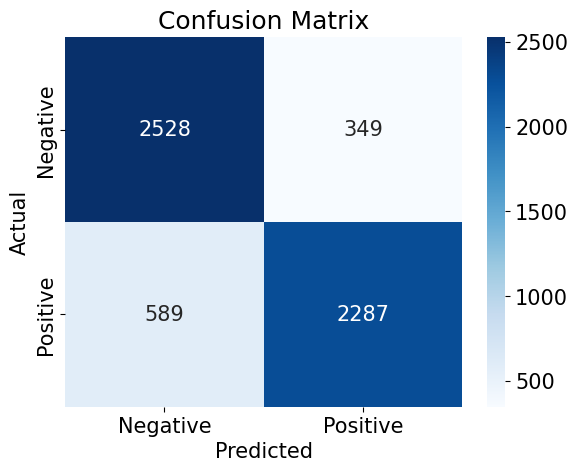

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(y_test.count())
plt.show()

Tổng quan thì mô hình cho ra kết quả tương đối tốt với các chỉ số precision, recall và f1-score cao cho cả hai nhãn và đạt độ chính xác (accuracy) là 84% trên tập kiểm tra.

#4 - Triển khai mô hình.

## 4.1 Lưu pipeline tốt nhất.

In [ ]:
import pickle
# save to file
file = open('best_pipe.bin', 'wb')
pickle.dump(selected_pipe, file)

## 4.2 Ứng dụng pipeline

### 4.2.1 Làm sạch tập **test**

In [ ]:
def clean_test_set(df):
    clean_experience(df)
    clean_NAN(df)
    clean_company_size_1(df)
    clean_last_new_job(df)
    clean_city(df)
    clean_relevent_experience(df)
    df_one_hot = apply_one_hot_encoding(df)
    clean_company_size_2(df_one_hot)
    df_final = remove_columns(df_one_hot)
    return df_final,X

df_test_final, X = clean_test_set(test)

tạo ra **X_f_Test** để tránh mất mát dữ liệu

In [ ]:
X_f_Test = X.copy()

### 4.2.2 Tải và dựa đoán tập test

In [ ]:
file = open('best_pipe.bin', 'rb')
predictor = pickle.load(file)
file.close()

In [ ]:
X_f_Test.shape

(28762, 32)

In [ ]:
y_pred_f = selected_pipe.predict(X_f_Test)

In [ ]:
print(y_pred_f[:30])

[0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1.]


Kết quả dự đoán đúng với kỳ vọng là 0 (không chuyển đổi công việc) và 1 (chuyển đổi công việc).

# 5. Kết luận
Bài báo dựa trên quá trình xây dựng mô hình phân loại giữa 2 nhãn 0 (không chuyển đổi việc làm) và 1 (Chuyển đổi việc làm).


- Sử dụng pipe line để tìm ra phương pháp scaling và phân loại tốt nhất trong các phương đã đề ra.
- **MinMaxScaler `kết hợp` RandomForestClassifier** là mô hình có hiệu suất tốt nhất, dựa trên chỉ số **Accuracy**.

- Mô hình đã có thể dự đoán trên tập kiểm tra riêng biệt, dự đoán và in ra nhãn đúng với kỳ vọng, nhưng chưa thể xác thực được độ chính xác (Lý do: không có nhãn cho tập test riêng ).
- Cần cải tiến và áp dụng 1 số phương pháp khác để có kết quả tốt hơn như giảm số chiều, mạng nơ ron, ...
